## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
from torch.nn import Linear,Embedding,Sequential,ReLU,Dropout,BatchNorm1d,CrossEntropyLoss,Sigmoid
from torch.optim import Adam,RMSprop
from torch.autograd import Variable
import torch.nn.functional as F
from random import sample
from torch import nn
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import torch

SEED = 42
np.random.seed(SEED)

In [2]:
torch.cuda.is_available() 

True

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
# if not os.path.exists('sonnets.txt'):
#     !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

# with open('sonnets.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# TEXT_START = 45
# TEXT_END = -368
# text = text[TEXT_START : TEXT_END]
# assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
# print('OK!')

### Data loading: "Евгений Онегин"


In [5]:
if not os.path.exists('onegin.txt'):
    !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.


text = ' '.join(text).lower()

# Оставляем только русские буквы (включая Ё/ё) и знаки препинания
text = re.sub(r"[^а-яА-ЯёЁ.,!?;:\-()\"'«»\s]", "", text)

# Удаляем строки, содержащие только переносы строк или пробелы
text = "\n".join(line for line in text.splitlines() if re.search(r"[а-яА-ЯёЁ.,!?;:\-()\"'«»]", line))

# Выводим первые 8 строк
print(text[:225])  

 «мой дядя самых честных правил,
 когда не в шутку занемог,
 он уважать себя заставил
 и лучше выдумать не мог.
 его пример другим наука;
 но, боже мой, какая скука
 с больным сидеть и день и ночь,
 не отходя ни шагу прочь!
 


Put all the characters, that you've seen in the text, into variable `tokens`.

In [7]:
# сделали множество с используемыми токенами
tokens = sorted(set(text)) + ['<sos>']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [8]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here

# создаем 2 словаря (индекс : токен) и (токен : индекс)


id_to_token = {idx: token for idx, token in enumerate(tokens)}
token_to_id = {token: idx for idx, token in enumerate(tokens)}

num_tokens = len(tokens)
text_encoded = [token_to_id[x] for x in text]
print(f"Токены:  {token_to_id}")

Токены:  {'\n': 0, ' ': 1, '!': 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, ':': 8, ';': 9, '?': 10, '«': 11, '»': 12, 'а': 13, 'б': 14, 'в': 15, 'г': 16, 'д': 17, 'е': 18, 'ж': 19, 'з': 20, 'и': 21, 'й': 22, 'к': 23, 'л': 24, 'м': 25, 'н': 26, 'о': 27, 'п': 28, 'р': 29, 'с': 30, 'т': 31, 'у': 32, 'ф': 33, 'х': 34, 'ц': 35, 'ч': 36, 'ш': 37, 'щ': 38, 'ъ': 39, 'ы': 40, 'ь': 41, 'э': 42, 'ю': 43, 'я': 44, 'ё': 45, '<sos>': 46}


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [9]:
BATCH_SIZE = 256
SEQ_LEN = 150
start_column = np.zeros((BATCH_SIZE, 1), dtype=int) + token_to_id['<sos>']

print("Наибольшее количество разных бачей которые можно получить из данных: ", (len(text_encoded) - SEQ_LEN + 1) // (BATCH_SIZE * SEQ_LEN))
def generate_chunk():
    global text_encoded, start_column

    start_index = np.random.randint(0, len(text_encoded) - BATCH_SIZE*SEQ_LEN - 1)
    data = np.array(text_encoded[start_index:start_index + BATCH_SIZE*SEQ_LEN]).reshape((BATCH_SIZE, -1))
    yield np.hstack((start_column, data))


Наибольшее количество разных бачей которые можно получить из данных:  3


In [10]:
next(generate_chunk())

array([[46, 27, 28, ...,  0,  1, 30],
       [46,  1, 25, ..., 36, 26, 40],
       [46, 34,  1, ..., 44, 31,  1],
       ...,
       [46, 13, 19, ..., 17, 35, 13],
       [46, 31, 41, ...,  0,  1, 21],
       [46,  1, 17, ..., 19, 21, 20]])

In [11]:

class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        
        super(VanillaRNN, self).__init__()
        
        # Сохранение размерности скрытого слоя
        self.hidden_size = hidden_size
        
        # Слой эмбеддинга для преобразования входных индексов в плотные векторы
        self.embedding = Embedding(vocab_size, hidden_size)
        
        # Слой простой рекуррентной нейронной сети (RNN)
        self.rnn = nn.RNN(
            input_size=hidden_size,   # Размерность входных данных
            hidden_size=hidden_size,  # Размерность скрытого слоя
            num_layers=num_layers,    # Количество слоёв RNN
            batch_first=True          # Указание, что батч идет первым в тензоре
        )
        
        # Полносвязный слой для вывода предсказаний (логиты)
        self.fc = Linear(hidden_size, vocab_size)

    # Функция прямого прохода данных через сеть
    def forward(self, x):
        # Преобразование входных индексов в эмбеддинги
        embedded = self.embedding(x)
        
        # Пропуск эмбеддингов через слой RNN
        output, _ = self.rnn(embedded)  # _ - скрытое состояние, которое мы не используем здесь
        
        # Преобразование вывода RNN в логиты через полносвязный слой
        logits = self.fc(output)
        
        # Возвращение логитов
        return logits

In [12]:
from torch.optim.lr_scheduler import StepLR


# Гиперпараметры
HIDDEN_SIZE = 128
NUM_LAYERS = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 10000  # Количество эпох

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Инициализация модели, функции потерь и оптимизатора
vocab_size = len(token_to_id)
model_rnn = VanillaRNN(vocab_size, HIDDEN_SIZE, NUM_LAYERS).to(device)

criterion = CrossEntropyLoss()
optimizer = Adam(model_rnn.parameters(), lr=LEARNING_RATE)

scheduler = StepLR(optimizer, step_size=3000, gamma=0.5)


# Тренировочный процесс
loss_history = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    epoch_loss = 0.0
    for batch_idx, batch in enumerate(generate_chunk()):
        # Перенос батча на устройство
        batch = torch.tensor(batch, dtype=torch.long).to(device)  # Преобразуем батч в тензор
        x, y = batch[:, :-1], batch[:, 1:]  # Входы и целевые значения (следующий токен)

        # Прямой проход
        logits = model_rnn(x)
        loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))

        # Обратное распространение
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Логирование
        epoch_loss += loss.item()
        loss_history.append(loss.item())

    print(f"End of Epoch {epoch + 1}: Average Loss = {epoch_loss / (batch_idx + 1):.4f}")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    scheduler.step()

Using device: cuda
Epoch 1/10000
End of Epoch 1: Average Loss = 3.8488
Learning Rate: 0.001000
Epoch 2/10000
End of Epoch 2: Average Loss = 3.7707
Learning Rate: 0.001000
Epoch 3/10000
End of Epoch 3: Average Loss = 3.6896
Learning Rate: 0.001000
Epoch 4/10000
End of Epoch 4: Average Loss = 3.5994
Learning Rate: 0.001000
Epoch 5/10000
End of Epoch 5: Average Loss = 3.4964
Learning Rate: 0.001000
Epoch 6/10000
End of Epoch 6: Average Loss = 3.3939
Learning Rate: 0.001000
Epoch 7/10000
End of Epoch 7: Average Loss = 3.2952
Learning Rate: 0.001000
Epoch 8/10000
End of Epoch 8: Average Loss = 3.2275
Learning Rate: 0.001000
Epoch 9/10000
End of Epoch 9: Average Loss = 3.1931
Learning Rate: 0.001000
Epoch 10/10000
End of Epoch 10: Average Loss = 3.1760
Learning Rate: 0.001000
Epoch 11/10000
End of Epoch 11: Average Loss = 3.1472
Learning Rate: 0.001000
Epoch 12/10000
End of Epoch 12: Average Loss = 3.1303
Learning Rate: 0.001000
Epoch 13/10000
End of Epoch 13: Average Loss = 3.1094
Learning 

Plot the loss function (axis X: number of epochs, axis Y: loss function).

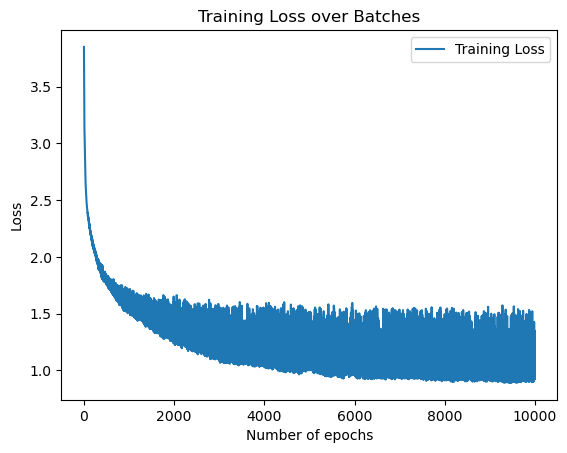

In [13]:
# Визуализация лосса
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Batches')
plt.legend()
plt.show()

In [14]:
def generate_sample(char_rnn, seed_phrase=None, max_length=100, temperature=1.0, device=device):
    '''
    Генерация текста на основе заданной фразы минимальной длины SEQ_LENGTH.
    
    :param seed_phrase: Префикс символов. RNN продолжает эту фразу
    :param max_length: Максимальная длина вывода, включая seed_phrase
    :param temperature: Коэффициент для выборки. Более высокая температура производит более хаотичный вывод,
                        более низкая температура сходится к единственному наиболее вероятному выводу
    :param char_rnn: Обученная модель RNN, используемая для генерации
    :param device: Устройство для запуска генерации (например, 'cpu' или 'cuda')
    '''
    
    if seed_phrase is not None:
        x_sequence = [token_to_id['<sos>']] + [token_to_id[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_id['<sos>']]
    
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    generated_sequence = x_sequence.tolist()[0]
    char_rnn.eval()
    hidden_state = None
    
    # Генерируем текст до достижения максимальной длины
    for _ in range(max_length - len(generated_sequence)):
        # Берём последний токен и пропускаем его через модель
        input_token = x_sequence[:, -1:]                             # Берём последний токен как вход
        embedded = char_rnn.embedding(input_token)                   # Преобразуем в эмбеддинг
        output, hidden_state = char_rnn.rnn(embedded, hidden_state)  # Пропускаем через RNN
        logits = char_rnn.fc(output[:, -1, :])                       # Получаем логиты из последнего временного шага
        
        # Применяем температурное масштабирование и выборку
        logits = logits / temperature
        probabilities = torch.softmax(logits, dim=-1).cpu().data.numpy()[0]
        next_token = np.random.choice(len(probabilities), p=probabilities)
        
        # Добавляем сгенерированный токен к последовательности
        generated_sequence.append(next_token)
        
        # Обновляем вход для следующего шага
        x_sequence = torch.tensor([[next_token]], dtype=torch.int64).to(device)
        
    return ''.join([tokens[ix] for ix in generated_sequence[1:]])  # исключаем <sos> токен

In [15]:
# Пример сгенерированного текста

input_seq = ' заботами, мечтами прошли года '.lower()
print("\nТемпература 0.2\n")
print(generate_sample(model_rnn, input_seq, max_length=300, temperature=0.2))
print("\nТемпература 0.7\n")
print(generate_sample(model_rnn, input_seq, max_length=300, temperature=0.6))


Температура 0.2

 заботами, мечтами прошли года не наслевого романа
 мне делах из и старушки,
 во всем пламенной душой,
 когда б онягиле пас,
 поэт до мне дней жизни зрех,
 с ольгой сумают,
 которой багрын стороненной досков.
 в любила разбездной как наконец
 привечало под ненчистоян.
 «ну, как наш он поток
 пленял

Температура 0.7

 заботами, мечтами прошли года нам покойный ручья бы нягойжелы,
 татьяна в пленной небесть
 она в снеге со стало
 предодах печальный уголь, холодной
 пора может бурестной душою,
 одно над не было, друзья!
 гляния с ним печальных промолоны.
 она без сам обедь, дев повелели вол,
 пока ляня, как путь 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [16]:
class CharLSTM(nn.Module):
    """
    Инициализация модели CharLSTM.

    :param vocab_size: Размер словаря (количество уникальных символов)
    :param hidden_size: Размер скрытого состояния LSTM
    :param embed_size: Размер эмбеддинга (по умолчанию 128)
    :param num_layers: Количество слоев LSTM (по умолчанию 2)
    """
    def __init__(self, vocab_size, hidden_size, embed_size=128, num_layers=2):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Слой эмбеддинга для преобразования входных индексов в плотные векторы
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Слой LSTM
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Полносвязный слой для вывода прогнозов (логитов)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden_state=None):
        """
        Прямой проход через модель.

        :param x: Входные индексы размера (batch_size, seq_length)
        :param hidden_state: Состояние LSTM (по умолчанию None)
        :return: Логиты и состояние LSTM
        """
        # x: Входные индексы размера (batch_size, seq_length)

        # Преобразование входных индексов в эмбеддинги
        x = self.embedding(x)  # размер: (batch_size, seq_length, embed_size)

        # Прохождение эмбеддингов через LSTM
        out, hidden_state = self.lstm(x, hidden_state)

        # Прохождение выводов LSTM через полносвязный слой для каждого шага времени
        out = self.fc(out)  # размер: (batch_size, seq_length, vocab_size)

        return out, hidden_state  # Возвращение логитов и состояния LSTM

In [ ]:

HIDDEN_SIZE = 128
NUM_LAYERS = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 10000  # Количество эпох
embed_size = 128  # Пример размера эмбеддинга

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")

# Инициализация модели, функции потерь и оптимизатора
vocab_size = len(token_to_id)  # Предполагаем, что token_to_id определено где-то
model_lstm = CharLSTM(vocab_size, HIDDEN_SIZE, embed_size=embed_size, num_layers=NUM_LAYERS).to(device)

criterion = CrossEntropyLoss()
optimizer = Adam(model_lstm.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=3000, gamma=0.5)

# Цикл обучения
loss_history = []

for epoch in range(NUM_EPOCHS):
    print(f"Эпоха {epoch + 1}/{NUM_EPOCHS}")
    epoch_loss = 0.0
    hidden_state = None  # Инициализация скрытого состояния для LSTM

    for batch_idx, batch in enumerate(generate_chunk()):
        # Переносим батч на устройство
        batch = torch.tensor(batch, dtype=torch.long).to(device)  # Преобразуем батч в тензор
        x, y = batch[:, :-1], batch[:, 1:]  # Входные данные и целевые значения (следующий токен)

        # Прямой проход
        logits, hidden_state = model_lstm(x, hidden_state)  # Прохождение через CharLSTM

        # Изменение формы логитов и целевых тензоров для расчета лосса
        logits = logits.reshape(-1, vocab_size)  # Форма: (batch_size * seq_length, vocab_size)
        y = y.reshape(-1)  # Форма: (batch_size * seq_length)

        # Расчет потерь
        loss = criterion(logits, y)

        # Обратный проход и обновление параметров
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Для графика истории
        epoch_loss += loss.item()
        loss_history.append(loss.item())

    # Печать среднего лосса для эпохи
    print(f"Конец эпохи {epoch + 1}: Средняя потеря = {epoch_loss / (batch_idx + 1):.4f}")
    print(f"Скорость обучения: {scheduler.get_last_lr()[0]:.6f}")
    scheduler.step()

Используем устройство: cuda
Эпоха 1/10000
Конец эпохи 1: Средняя потеря = 3.8477
Скорость обучения: 0.001000
Эпоха 2/10000
Конец эпохи 2: Средняя потеря = 3.8313
Скорость обучения: 0.001000
Эпоха 3/10000
Конец эпохи 3: Средняя потеря = 3.8135
Скорость обучения: 0.001000
Эпоха 4/10000
Конец эпохи 4: Средняя потеря = 3.7926
Скорость обучения: 0.001000
Эпоха 5/10000
Конец эпохи 5: Средняя потеря = 3.7667
Скорость обучения: 0.001000
Эпоха 6/10000
Конец эпохи 6: Средняя потеря = 3.7323
Скорость обучения: 0.001000
Эпоха 7/10000
Конец эпохи 7: Средняя потеря = 3.6833
Скорость обучения: 0.001000
Эпоха 8/10000
Конец эпохи 8: Средняя потеря = 3.6157
Скорость обучения: 0.001000
Эпоха 9/10000
Конец эпохи 9: Средняя потеря = 3.5250
Скорость обучения: 0.001000
Эпоха 10/10000
Конец эпохи 10: Средняя потеря = 3.4240
Скорость обучения: 0.001000
Эпоха 11/10000
Конец эпохи 11: Средняя потеря = 3.3491
Скорость обучения: 0.001000
Эпоха 12/10000
Конец эпохи 12: Средняя потеря = 3.3110
Скорость обучения: 0.0

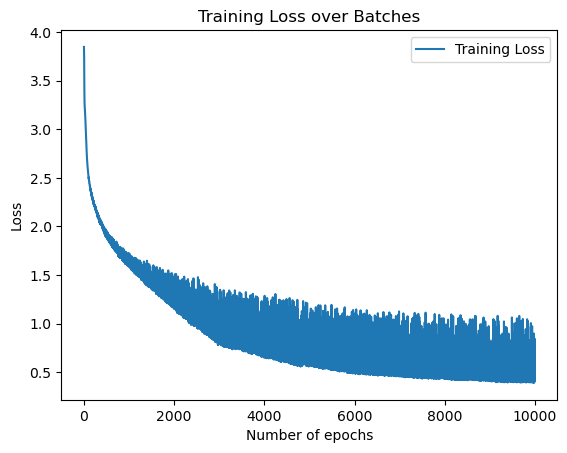

In [18]:
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Batches')
plt.legend()
plt.show()

In [ ]:
def generate_sample_lstm(char_lstm, seed_phrase=None, max_length=100, temperature=1.0, device=device):
    '''
    Функция генерирует текст, начиная с фразы длиной не менее SEQ_LENGTH.
    :param seed_phrase: начальная фраза (префикс). LSTM будет продолжать эту фразу.
    :param max_length: максимальная длина выходного текста, включая начальную фразу.
    :param temperature: коэффициент для семплирования. Более высокое значение приводит к более хаотичному результату,
                        меньшее значение заставляет сеть выбирать наиболее вероятный результат.
    :param char_lstm: обученная модель CharLSTM, используемая для генерации.
    :param device: устройство для выполнения генерации (например, 'cpu' или 'cuda').
    '''
    
    if seed_phrase is not None:
        x_sequence = [token_to_id['<sos>']] + [token_to_id[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_id['<sos>']]
    
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    generated_sequence = x_sequence.tolist()[0]  # Инициализация выходной последовательности начальной фразой
    
    char_lstm.eval()  # Перевод модели в режим оценки
    hidden_state = None  # Инициализация скрытого состояния для LSTM
    
    for _ in range(max_length - len(generated_sequence)):
        # Получить последний токен и передать его через модель
        input_token = x_sequence[:, -1:]  # Взять последний токен в качестве входа
        embedded = char_lstm.embedding(input_token)  # Преобразование в embedding
        output, hidden_state = char_lstm.lstm(embedded, hidden_state)  # Пропуск через LSTM
        
        # Получить выход для последнего временного шага
        output = output[:, -1, :]  # Взять выход последнего временного шага
        
        # Получить логиты из полносвязного слоя
        logits = char_lstm.fc(output)  # Получить логиты из финального слоя
        
        # Применить масштабирование температуры и семплирование
        logits = logits / temperature
        probabilities = torch.softmax(logits, dim=-1).cpu().data.numpy()[0]
        next_token = np.random.choice(len(probabilities), p=probabilities)
        
        # Добавить сгенерированный токен в последовательность
        generated_sequence.append(next_token)
        
        # Обновить вход для следующего шага
        x_sequence = torch.tensor([[next_token]], dtype=torch.int64).to(device)
    
    return ''.join([tokens[ix] for ix in generated_sequence[1:]])  # Пропустить токен <sos>


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [20]:
# Генерация текста с разными значениями температуры
input_seq = ' заботами, мечтами прошли года '.lower()
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]

for temp in temperatures:
    print(f"\nТемпература {temp} \n")
    print(generate_sample_lstm(model_lstm, input_seq, max_length=240, temperature=temp))
    


Температура 0.1 

 заботами, мечтами прошли года сулею
 медленной страсть изорупенье
 с своей доскорой влевой.
 со временем издает он.
 татьяна в следа молодой,
 татьяна жертвой тебя;
 зарецкий ум ок шум, еще
 встает несется воспом,
 и мадригалы осуждей;
 з

Температура 0.2 

 заботами, мечтами прошли года сердца ждет
 как услужду воображенье.
 утра иль нетерпели славил,
 хранили врагам одева».
 «ак, не всё, в полный вздоры;
 не мог безмого ни стола.
 принуждал перед ними пиной
 она долго плакала бары,
 так раб

Температура 0.5 

 заботами, мечтами прошли года сулетет,
 огнемноженной повторилась,
 как смиравно умное слыхал,
 и глухой мглих ленский; празднильный
 поспер неукрассой округом
 на то блестыская застроит,
 примут навского полых их
 благослошная пред садой

Температура 1.0 

 заботами, мечтами прошли года сорать?
 воздала липья унислать во:
 она отпросту разборбы
 их на крелас уж полыбленно
 зимой и безумством силить
 сам оборотует,
 оспичускамудут братель,
 старушке, за ним 

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [21]:
# Сохраняем и загружаем модель
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def save_model(model, file_path):
    torch.save(model, file_path)
    print(f"Модель успешно сохранена в файл: {file_path}")

def load_and_evaluate_model(file_path):
    model_loaded = torch.load(file_path, map_location=torch.device('cpu'))
    model_loaded.eval()
    print("Модель успешно загружена и переведена в режим оценки\n")
    return model_loaded

def generate_text(model, seed_text, num_generate, temperature):
    generated_text = generate_sample_lstm(model, seed_text, max_length=num_generate, temperature=temperature, device=device)
    print(f"Сгенерированный текст:\n\n{generated_text}")

# Путь к файлу модели
model_file_path = 'model.pth'

# Сохранение модели
save_model(model_lstm, model_file_path)

# Загрузка и оценка модели
model_loaded = load_and_evaluate_model(model_file_path)

# Параметры генерации текста
seed_text = " Идут года, чего уж боле ".lower()
num_generate = 400
temperature = 0.1

# Генерация текста
generate_text(model_loaded.to(device), seed_text, num_generate, temperature)

Модель успешно сохранена в файл: model.pth
Модель успешно загружена и переведена в режим оценки

Сгенерированный текст:

 идут года, чего уж боле сулетет,
 огнемноженной повторилась,
 при их необразы пышной,
 но следственным севенный злан,
 не вспомнился я вас поэта,
 но ольге надежду одина,
 возовет старинных прикусь.
 ужин, и сельнет умолкнов,
 всё в эти мельяним с нею снимлидь
 стал приятель роскорей,
 роспой старинные ласков.
 сосед первыми слабогода,
 припрачный котран, тольком,
 смиренно решесновозум,
 как он


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)